<a href="https://colab.research.google.com/github/malakaydi/Facial-Recognition/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload your Kaggle API credentials JSON file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"malakaidi","key":"72166fe48a81838e2687ddd07613f781"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d maciejgronczynski/biggest-genderface-recognition-dataset

100% 438M/439M [00:16<00:00, 36.3MB/s]
100% 439M/439M [00:16<00:00, 28.5MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('biggest-genderface-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

Visualizing images from 'woman' subdirectory:
Visualizing images from 'man' subdirectory:


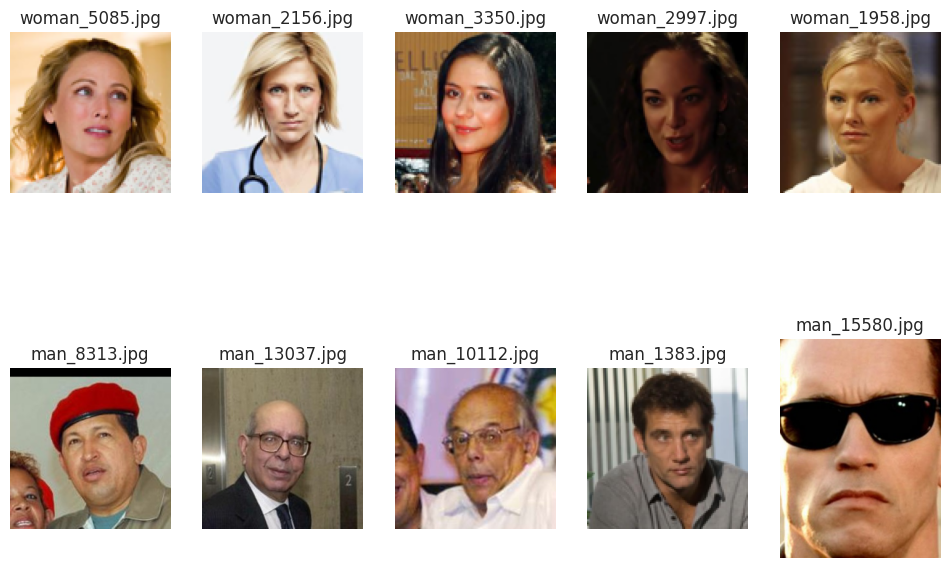

In [ ]:
# Define the dataset directory
dataset_dir = 'data'

# Visualize some images from the dataset
subdirectories = os.listdir(os.path.join(dataset_dir, 'faces'))
plt.figure(figsize=(12, 8))

for i, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(dataset_dir, 'faces', subdir)
    image_files = os.listdir(subdir_path)

    print(f"Visualizing images from '{subdir}' subdirectory:")

    num_images_to_display = min(5, len(image_files))

    for j in range(num_images_to_display):
        image_filename = image_files[j]
        image_path = os.path.join(subdir_path, image_filename)
        image = Image.open(image_path)

        subplot_index = i * num_images_to_display + j + 1

        plt.subplot(len(subdirectories), num_images_to_display, subplot_index)
        plt.imshow(image)
        plt.title(image_filename)
        plt.axis('off')

plt.show()

In [ ]:
# Define parameters for data preprocessing
batch_size = 32
input_shape = (224, 224, 3)

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Experiment with rotation
    width_shift_range=0.2,  # Experiment with width shift
    height_shift_range=0.2,  # Experiment with height shift
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'faces'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'faces'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 21735 images belonging to 2 classes.
Found 5432 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
epochs = 2  # Adjust as needed

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/2
679/679 [==============================] - 3043s 4s/step - loss: 0.5568 - accuracy: 0.7120 - val_loss: 0.5577 - val_accuracy: 0.7149
Epoch 2/2
127/679 [====>.........................] - ETA: 37:09 - loss: 0.5135 - accuracy: 0.7353

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# Load and preprocess your photo
your_photo_path = 'malak.jpg'  # Replace with the actual path to your photo
your_photo = Image.open(your_photo_path)
your_photo = your_photo.resize((150, 150))
your_photo = np.array(your_photo) / 255.0

# Make a prediction
predicted_prob = model.predict(np.array([your_photo]))

# Set a threshold
threshold = 0.5

if predicted_prob > threshold:
    print("Predicted: Woman")
else:
    print("Predicted: Man")